In [59]:
import pandas as pd
import numpy as np
import statsmodels
#import fix_yahoo_finance as yf
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import quandl
import monthly_returns_heatmap as mrh
import matplotlib.dates as dates
import bt

In [61]:
tickers='CHRIS/CME_GC1'   
data=quandl.get(tickers)
datestart='2015-01-01'

In [63]:
#เนื่องจากใช้ quandl ในการโหลดข้อมูล ทองคำ มันจะใช้ราคา Last
gold=pd.concat([data['Last'].loc[datestart: pd.to_datetime('now')]]
               ,axis=1,keys=['Close'])

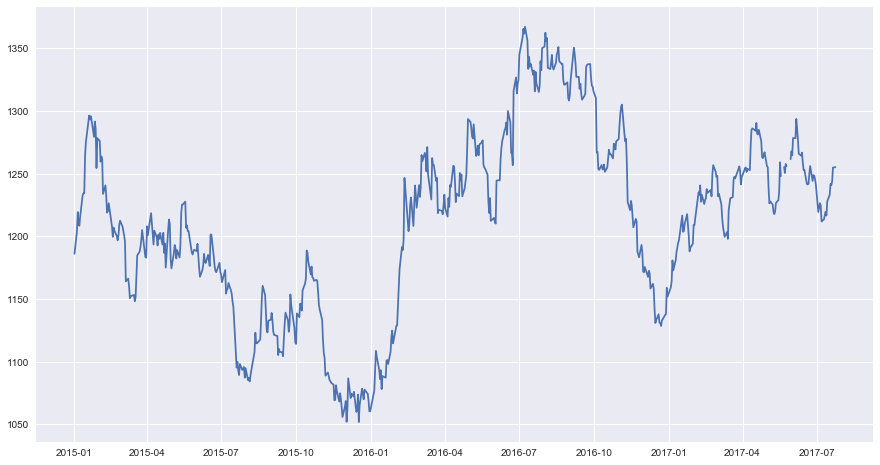

In [64]:
plt.figure(figsize=(15,8));
plt.plot(gold);

In [10]:
dailyreturn=pd.concat([gold['Close'].pct_change(1)]
                      ,axis=1,keys=['DailyReturn'])
monthlyreturn=pd.concat([gold['Close'].pct_change(21)]
                      ,axis=1,keys=['MonthlyReturn'])
annualreturn=pd.concat([gold['Close'].pct_change(252)]
                      ,axis=1,keys=['AnnualReturn'])

In [11]:
goldreturn=pd.concat([gold['Close'],dailyreturn,monthlyreturn,annualreturn],
                    axis=1)                   

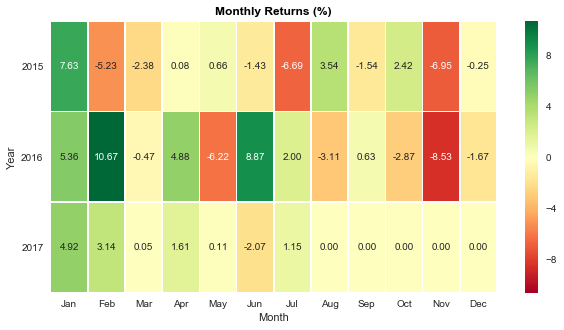

In [12]:
plt.figure(figsize=(10,8));
mrh.plot(dailyreturn)

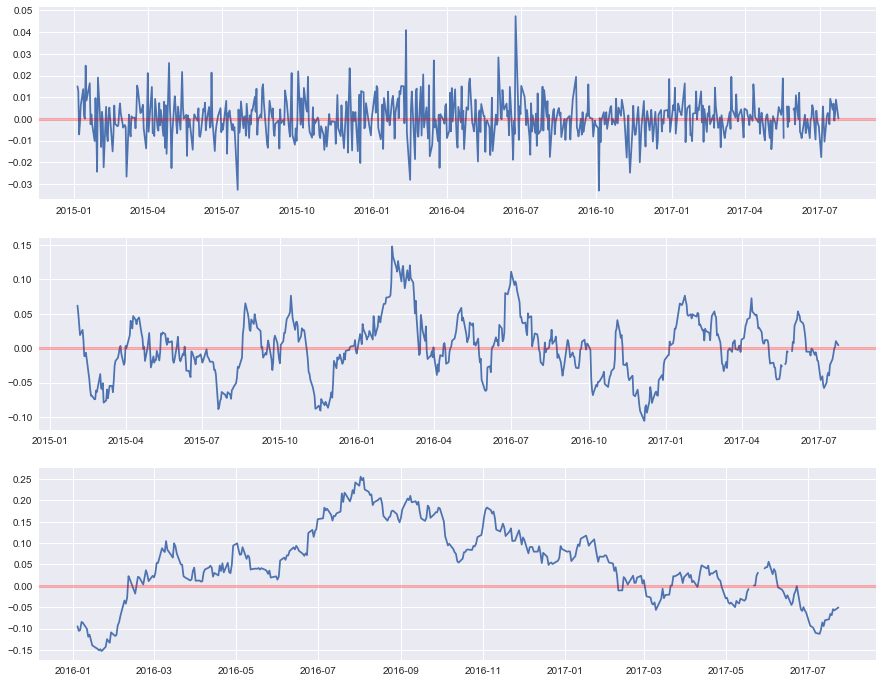

In [13]:
plt.figure(figsize=(15,12));
plt.subplot(311);
plt.plot(goldreturn['DailyReturn']);
plt.axhline(y=0, linewidth=3,color='r',alpha=0.3);
plt.subplot(312);
plt.plot(goldreturn['MonthlyReturn']);
plt.axhline(y=0, linewidth=3,color='r',alpha=0.3);
plt.subplot(313);
plt.plot(goldreturn['AnnualReturn']);
plt.axhline(y=0, linewidth=3,color='r',alpha=0.3);

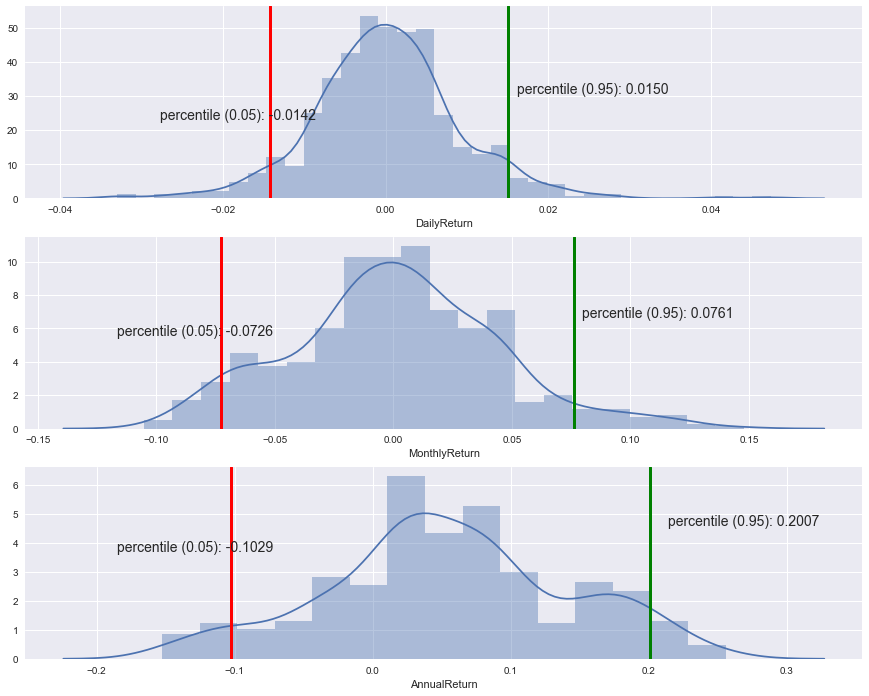

In [14]:
plt.figure(figsize=(15,12));
plt.subplot(311);
sns.distplot(goldreturn['DailyReturn'].dropna());
p=np.percentile(goldreturn['DailyReturn'].dropna(),5)
q=np.percentile(goldreturn['DailyReturn'].dropna(),95)
plt.axvline(x=p, linewidth=3,color='r');
plt.axvline(x=q, linewidth=3,color='g');
plt.figtext(0.25,0.75,"percentile (0.05): %.4f" % p,fontsize=14);
plt.figtext(0.58,0.78,"percentile (0.95): %.4f" % q,fontsize=14);

plt.subplot(312);
sns.distplot(goldreturn['MonthlyReturn'].dropna());
p=np.percentile(goldreturn['MonthlyReturn'].dropna(),5)
q=np.percentile(goldreturn['MonthlyReturn'].dropna(),95)
plt.axvline(x=p, linewidth=3,color='r');
plt.axvline(x=q, linewidth=3,color='g');
plt.figtext(0.21,0.50,"percentile (0.05): %.4f" % p,fontsize=14);
plt.figtext(0.64,0.52,"percentile (0.95): %.4f" % q,fontsize=14);

plt.subplot(313);
sns.distplot(goldreturn['AnnualReturn'].dropna());
p=np.percentile(goldreturn['AnnualReturn'].dropna(),5)
q=np.percentile(goldreturn['AnnualReturn'].dropna(),95)
plt.axvline(x=p, linewidth=3,color='r');
plt.axvline(x=q, linewidth=3,color='g');
plt.figtext(0.21,0.25,"percentile (0.05): %.4f" % p,fontsize=14);
plt.figtext(0.72,0.28,"percentile (0.95): %.4f" % q,fontsize=14);

In [15]:
dailymean=goldreturn['DailyReturn'].mean()
monthlymean=goldreturn['MonthlyReturn'].mean()
annualmean=goldreturn['AnnualReturn'].mean()
dailystd=goldreturn['DailyReturn'].std()
monthlystd=goldreturn['MonthlyReturn'].std()
annualstd=goldreturn['AnnualReturn'].std()

dailysharpe=np.sqrt(252)*(dailymean/dailystd)
monthlysharpe=np.sqrt(252)*(monthlymean/monthlystd)
annualsharpe=np.sqrt(252)*(annualmean/annualstd)

print ("Daily Sharpe Ratio = ",dailysharpe,"| Volatility = ",dailystd);
print ("Monthly Sharpe Ratio = ",monthlysharpe,"| Volatility = ",monthlystd);
print ("Annual Sharpe Ratio = ",annualsharpe,"| Volatility = ",annualstd);

Daily Sharpe Ratio =  0.226620659788 | Volatility =  0.00904202909262
Monthly Sharpe Ratio =  0.182788986455 | Volatility =  0.0438787591996
Annual Sharpe Ratio =  9.88055411099 | Volatility =  0.0875086703566


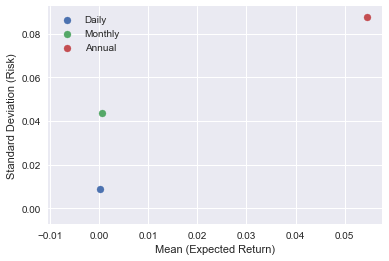

In [16]:
#plt.figure(figsize=(15,8));
daily=plt.scatter(dailymean,dailystd);
monthly=plt.scatter(monthlymean,monthlystd);
annual=plt.scatter(annualmean,annualstd);

plt.legend((daily,monthly,annual),('Daily','Monthly','Annual')
           ,loc='upper left',fontsize=10)
plt.xlabel('Mean (Expected Return)')
plt.ylabel('Standard Deviation (Risk)')
plt.show()

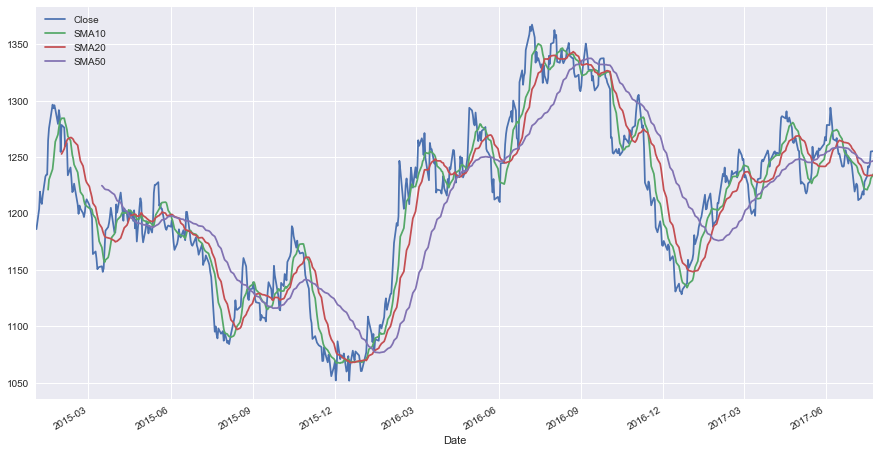

In [43]:
data=gold.dropna() # ถ้าไม่ใส่ dropna จะทำให้ไม่สามารถรันได้เพราะติดค่า Nan
sma10 = data.rolling(10).mean()
sma20= data.rolling(20).mean()
sma50= data.rolling(50).mean()
bt.merge(data,sma10,sma20,sma50).plot(figsize=(15, 8));
plt.legend(('Close','SMA10','SMA20','SMA50')
           ,loc='upper left',fontsize=10);

In [20]:
class SelectWhere(bt.Algo):
    def __init__(self, signal):
        self.signal = signal
    def __call__(self, target):
        # get signal on target.now
        if target.now in self.signal.index:
            sig = self.signal.ix[target.now]
            selected = list(sig.index[sig])
            target.temp['selected'] = selected
        return True

In [22]:
# สร้าง algorithm--moving average ตัดกัน
def above_sma(btdata, sma_per=50, start= datestart, name='above_sma'):
    sma = data.rolling(sma_per).mean()
    s = bt.Strategy(name, [SelectWhere(data > sma),
                           bt.algos.WeighEqually(),
                           bt.algos.Rebalance()])
    return bt.Backtest(s, data)

In [24]:
# สร้าง algorithm--long only
def long_only_ew(data, start=datestart, name='long_only_ew'):
    s = bt.Strategy(name, [bt.algos.RunOnce(),
                           bt.algos.SelectAll(),
                           bt.algos.WeighEqually(),
                           bt.algos.Rebalance()])
    return bt.Backtest(s, data)

In [26]:
sma10 = above_sma(data, sma_per=10, name='sma10')
sma20 = above_sma(data, sma_per=20, name='sma20')
sma50 = above_sma(data, sma_per=50, name='sma50')
benchmark = long_only_ew(data, name='LongOnly')

In [27]:
result= bt.run(sma10,sma20,sma50,benchmark)

sma10
0% [############################# ] 100% | ETA: 00:00:00sma20


/Users/joeaphiboon/Dropbox/MyPython PlayGround/PineApple Backup/Pineapple.app/Contents/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:21: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


0% [############################# ] 100% | ETA: 00:00:00sma50
0% [############################# ] 100% | ETA: 00:00:00LongOnly
0% [############################# ] 100% | ETA: 00:00:00

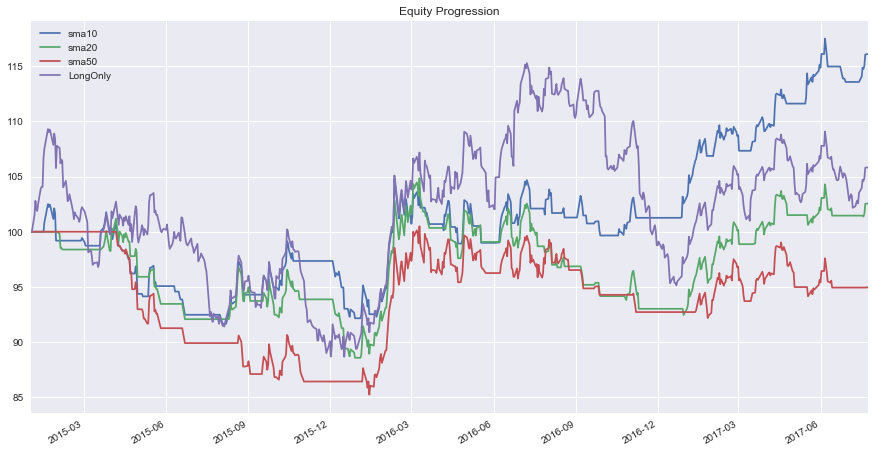

In [28]:
result.plot(figsize=(15,8));

In [29]:
result.display()

Stat                 sma10       sma20       sma50       LongOnly
-------------------  ----------  ----------  ----------  ----------
Start                2015-01-01  2015-01-01  2015-01-01  2015-01-01
End                  2017-07-24  2017-07-24  2017-07-24  2017-07-24
Risk-free rate       0.00%       0.00%       0.00%       0.00%

Total Return         16.09%      2.55%       -5.03%      5.83%
Daily Sharpe         0.64        0.15        -0.16       0.23
Daily Sortino        0.73        0.17        -0.19       0.36
CAGR                 6.00%       0.99%       -2.00%      2.24%
Max Drawdown         -10.57%     -12.46%     -14.76%     -18.87%
Calmar Ratio         0.57        0.08        -0.14       0.12

MTD                  2.22%       1.08%       0.02%       1.12%
3m                   4.02%       0.03%       -3.01%      -1.61%
6m                   7.89%       5.73%       1.28%       3.86%
YTD                  13.19%      10.92%      2.42%       8.97%
1Y                   13.70%      3.